## Изучения файлов и импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('users.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
df.describe()


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Посмотрим на корреляцию факторов между собой

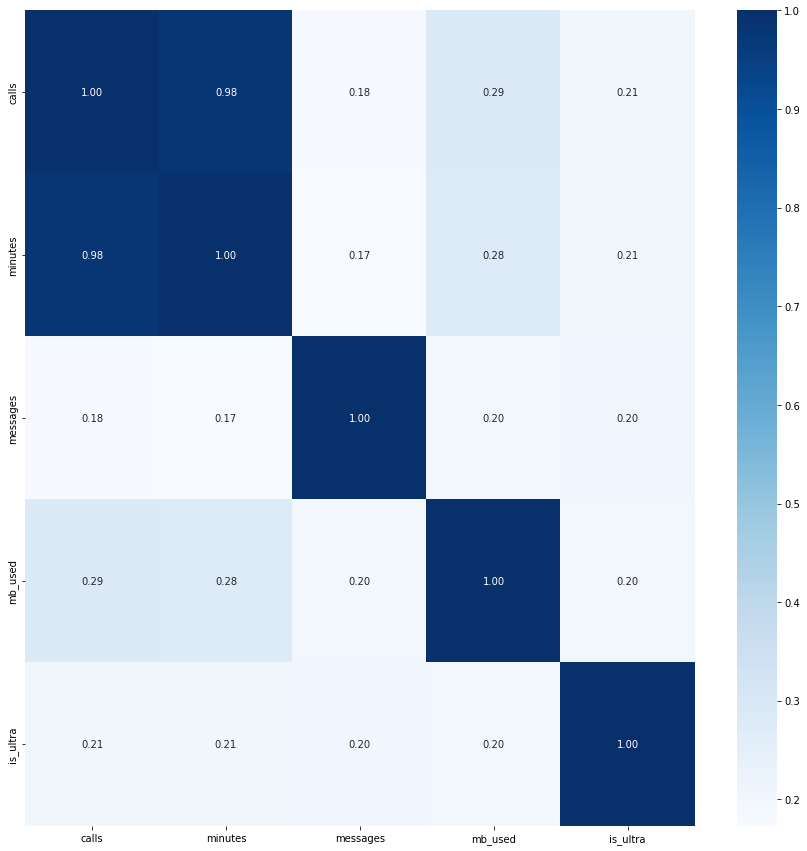

In [4]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(method='pearson'), annot=True, cmap="Blues", fmt='.2f')

Да, видно что звонки и затраченные минуты (очевидно) имеют сильную корреляцию. Уберём далее звонки (так как это те же минуты, только разбитые на блоки) для чистоты модели. 

## Разбейте данные на выборки

Разделим наш датасет на выборки. Сначала мы перетасуем весь набор данных (df.sample (frac = 1)), а затем разделим наш набор данных на следующие части:

- 50% - обучающая набор;
- 25% - валидационная набор;
- 25% - тестовый.

In [5]:
train, validate, test = np.split(df.sample(frac=1), [int(.5*len(df)), int(.75*len(df))])

Присвоим переменным признаки и целевые признаки

Валидационная выборка

In [6]:
features_valid = validate.drop(['is_ultra','calls'], axis=1)
target_valid = validate['is_ultra']

Обучающая выборка

In [7]:
features_train = train.drop(['is_ultra','calls'], axis=1)
target_train = train['is_ultra']

Тестовая выборка

In [8]:
features_test = test.drop(['is_ultra','calls'], axis=1)
target_test = test['is_ultra']

print('Размер валидационной выборки:', target_valid.shape[0])
print('Размер обучающей выборки:', target_train.shape[0])
print('Размер тестовой выборки:',target_test.shape[0])

Размер валидационной выборки: 803
Размер обучающей выборки: 1607
Размер тестовой выборки: 804


## Исследуйте модели

### Проверим модель Ближайших соседей:

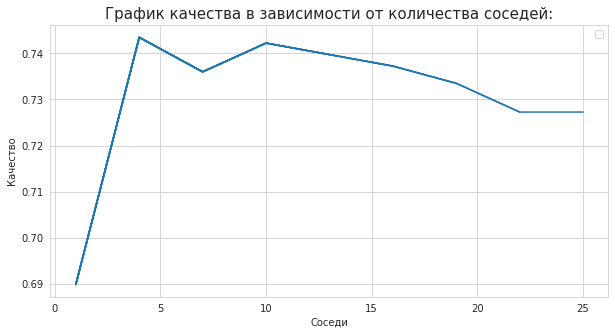

Accuracy наилучшей модели на валидационной выборке: 0.7434620174346201
Количество соседей: 4


In [9]:
sns.set_style(style="whitegrid")
neighbor = []
best_model = None
accuracy_n = []
best_neighbors = 0
best_result = 0
plt.figure(figsize=(10, 5))

for neighbors in range(1,28,3):
    model = KNeighborsClassifier(n_neighbors = neighbors)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    score = accuracy_score(target_valid, predictions)
    neighbor.append(neighbors)
    accuracy_n.append(score)
    sns.lineplot(data=pd.DataFrame(data=accuracy_n, index=neighbor))
    plt.legend('')
    if score > best_result:
       best_neighbors = neighbors
       best_result = score
       best_model = model
plt.title("График качества в зависимости от количества соседей:", fontsize=15) 
plt.ylabel("Качество") 
plt.xlabel("Соседи")
plt.show()
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Количество соседей:", best_neighbors)

### Проверим модель Дерево Решений:

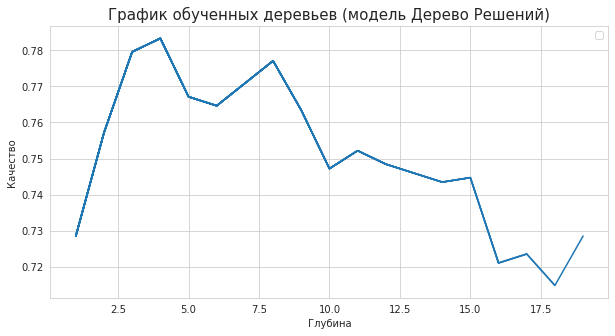

Accuracy наилучшей модели на валидационной выборке: 0.7833125778331258
Глубина: 4


In [10]:
depths = []
accuracy_t = []
best_model_t = None
best_result_t = 0
best_depth_t = 0
plt.figure(figsize=(10, 5))

for depth in range(1,20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    score = accuracy_score(target_valid, predictions)
    depths.append(depth)
    accuracy_t.append(score)
    if score > best_result_t:
      best_depth_t = depth
      best_result_t = score
      best_model_t = model
    sns.lineplot(data=pd.DataFrame(data=accuracy_t, index=depths))
    plt.legend('')
plt.title("График обученных деревьев (модель Дерево Решений)", fontsize=15) 
plt.ylabel("Качество") 
plt.xlabel("Глубина")
plt.show()

print("Accuracy наилучшей модели на валидационной выборке:", best_result_t)
print("Глубина:", best_depth_t)

### Проверим модель Случайный лес:


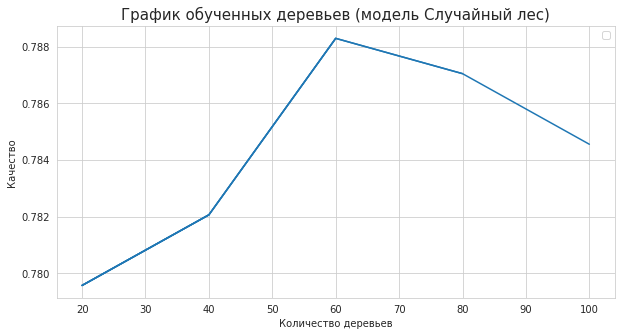

Количество деревьев: 60
Accuracy наилучшей модели на валидационной выборке: 0.788293897882939


In [11]:
best_model_f = None
estimators = []
accuracy_f = []
best_est_f  = 0
best_score_f  = 0
plt.figure(figsize=(10, 5))

for est in range(20,102,20):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    score = accuracy_score(target_valid, predictions)
    estimators.append(est)
    accuracy_f.append(score)
    sns.lineplot(data=pd.DataFrame(data=accuracy_f, index=estimators))
    plt.legend('')
    if score > best_score_f :
        best_model_f = model
        best_score_f  = score
        best_est_f  = est

plt.title("График обученных деревьев (модель Случайный лес)", fontsize=15) 
plt.ylabel("Качество") 
plt.xlabel("Количество деревьев")
plt.show()
print("Количество деревьев:", best_est_f) 
print("Accuracy наилучшей модели на валидационной выборке:", best_score_f)

### Проверим модель Логистической регрессии:

In [12]:
model = LogisticRegression(random_state=12345)
model.fit(features_train,target_train) 
result_log = model.score(features_valid,target_valid)

print("Accuracy модели логистической регрессии на валидационной выборке:", result_log)

Accuracy модели логистической регрессии на валидационной выборке: 0.7210460772104608



### Вывод:



Рассмотрены модели:
- Ближайшие соседи
- Дерево Решений
- Случайный лес
- Логистическая регрессия

In [13]:
 
 row= [
    ['Ближайшие соседи', " ", best_neighbors, best_result],
    ['Дерево Решений', best_depth_t, " ", best_result_t],
    ['Случайный лес', " ", best_est_f, best_score_f],
    ['Логистическая регрессия', " ", " ", result_log],
]


data = pd.DataFrame( row, columns = ['Модель', 'Глубина','Деревья/соседи','Accuracy'])
display(data)

,Модель,Глубина,Деревья/соседи,Accuracy
0,Ближайшие соседи,,4,0.743462
1,Дерево Решений,4,,0.783313
2,Случайный лес,,60,0.788294
3,Логистическая регрессия,,,0.721046


Выбраные модели (лучшие):
- Случайный лес


## Проверим модели на тестовой выборке

In [14]:
model1 = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=11)
model1.fit(features_train, target_train)
predictions1 = model1.predict(features_test)
score1 = accuracy_score(target_test, predictions1)
print('Случайный лес - Accuracy:', score1)

        

Случайный лес - Accuracy: 0.8246268656716418


## (бонус) Проверьте модели на адекватность

Допустим, что наша модель **Случайный лес** по дефолту всегда выбирает противоположный тариф, то есть ошибается:

In [15]:

df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Значит пороговая "тупая" черта равна 69%. В нашем случае модель адекватна, так как набрала больше 80%, что говорит о отсутствии предсказаний случайным образом.

Так же **Случайный лес в регресси** с такими же вводными - своим RMSE подтверждает нашу версию.

In [16]:
from sklearn.dummy import DummyClassifier
strategies = ['most_frequent']
dummy_results = []
for strategy in strategies:
  dc = DummyClassifier(strategy = strategy, random_state = 42)
  dc.fit(features_train, target_train)
  result = dc.score(features_test, target_test)
  dummy_results.append({strategy: result})
  print('Neighbors:', dummy_results)

Neighbors: [{'most_frequent': 0.6853233830845771}]


Похожее сравнение, как и доля нулей, которую мы взяли за основу при проверке "на глаз" адекватности нашей модели. И всё равно, даже при таком значении качества, наша модель показывает свою адекватность и будет полезна бизнесу.